In [13]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dc_stat_think as dcst

In [3]:
df = pd.read_csv('parkfield_earthquakes_1950-2017.csv', skiprows=2, parse_dates=['time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9991 entries, 0 to 9990
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             9991 non-null   datetime64[ns]
 1   latitude         9991 non-null   float64       
 2   longitude        9991 non-null   float64       
 3   depth            9991 non-null   float64       
 4   mag              9991 non-null   float64       
 5   magType          9991 non-null   object        
 6   nst              9990 non-null   float64       
 7   gap              9990 non-null   float64       
 8   dmin             9959 non-null   float64       
 9   rms              9989 non-null   float64       
 10  net              9991 non-null   object        
 11  id               9991 non-null   object        
 12  updated          9991 non-null   object        
 13  place            9991 non-null   object        
 14  type             9991 non-null   object 

First part: Earthquake magnitudes

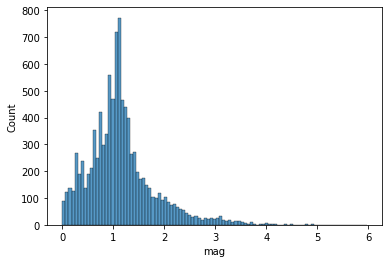

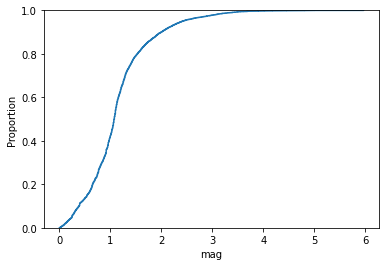

In [6]:
# Graphical EDA
# 1. Distribution of magnitude
_ = sns.histplot(data=df, x='mag')
plt.show()
_ = sns.ecdfplot(data=df, x='mag')
plt.show()

In [47]:
# 2. Compute b-value
def b_value(mag:np.array, mt:int, perc=[2.5,97.5], n_reps=None):
    '''
    Computes b_value of earthquake magnitudes
    mag = earthquake magnitudes
    mt = complete threshold of the earthquake
    perc = percentiles for confidence interval of bootstrap replicates, only n_reps is not None
    n_reps = bootstrap replicates to calculate

    return
    b_value if n_reps is None
    mean_b_value, confidence_interval
    '''
    # keep only mag above threshold
    mags_over_threshold = mag[mag >= mt]

    # no bootstrap replicates needed, just one calculation
    if n_reps == None:
        b_value = (np.mean(mags_over_threshold) - mt) * np.log(10)
        return b_value
    # calculate bootstrap replicates and confidence interval
    else:
        b_values = np.empty(n_reps)
        for i in range(n_reps):
            sample_mags = np.random.choice(mags_over_threshold, size=len(mags_over_threshold), replace=True)
            b_value = (np.mean(sample_mags) - mt) * np.log(10)
            b_values[i] = b_value
        return np.mean(b_values), np.percentile(b_values, perc)

# calculate average magnitude and b-value
mag = np.array(df['mag'])
mt = 3
print('average magnitude =', np.mean(mag))
b, conf_int = b_value(mag, mt, n_reps=1000)
print('b_value =', b, 'w/ 95% CI', conf_int)

average magnitude = 1.1543148833950558
b_value = 1.078931405027477 w/ 95% CI [0.939314   1.23699476]


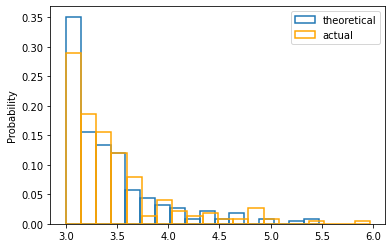

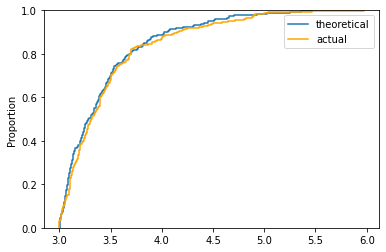

In [60]:
# 3. Prove Gutenberg-Richter Law
# Magnitudes of earthquakes are exponentially distributed
# Compare actual magnitudes over the threshold to that from the b_value
m_actual = mag[mag >= mt]
m_theor = np.random.exponential(scale=b/np.log(10), size=len(m_actual)) + mt

# Histogram
_ = sns.histplot(data=m_theor, fill=False, stat='probability')
_ = sns.histplot(data=m_actual, color='orange', fill=False, stat='probability')
plt.legend(loc='best', labels=['theoretical', 'actual'])
plt.show()
# ECDF
_ = sns.ecdfplot(data=m_theor)
_ = sns.ecdfplot(data=m_actual, color='orange')
plt.legend(loc='best', labels=['theoretical', 'actual'])
plt.show()

Second part: Time between earthquakes

In [84]:
# 1. Get a view of how often earthquakes occur in Parkfield
# sort df by time
df = df.sort_values(by='time', ascending=True)
# calculate time diff between consecutive earthquakes
time_between_eqs = df.time.diff().dropna() # or กรรมกร (df.time - df.time.shift(1))[1:]
# describe
time_between_eqs.describe()

count                          9990
mean      2 days 09:43:32.911153153
std      36 days 00:48:45.154518099
min          0 days 00:00:00.040000
25%          0 days 00:25:16.570000
50%          0 days 06:19:27.175000
75%          1 days 15:46:04.340000
max       3122 days 03:52:40.900000
Name: time, dtype: object

Most of them are not that far apart but those may be aftershocks.

In [ ]:
# filter our aftershocks